# Batched Bayesian Optimization

This example shows how to perform batched Bayesian optimization on a 6-dimensional synthetic test function.

For the surrogate model we use a GP with a simple RBF kernel and an exact likelihood.

For the Bayesian optimization we use the q-EI acquisition function. This uses the reparamaeterization trick to efficiently consider entire batches, rather than relying on the "fantasy" or "constant liar" trick. 

#### Set up oracle and random point sampler

In [2]:
import torch

from botorch.test_functions.hartmann6 import hartmann6, GLOBAL_MINIMUM

DATA_DIM = 6
MAX_VAL = -GLOBAL_MINIMUM


def oracle(X):
    """Oracle function for generating observations"""
    return -hartmann6(X)


def gen_x(num_samples):
    """Generate random points in the unit cube [0, 1]^6"""
    return torch.rand(num_samples, DATA_DIM)

#### Import a basic GP model

This is the model specification of a simple GP model in gpytorch, using a constant mean, RBF Kernel with Automatic Relevance Discovery (ARD)

In [3]:
from botorch.models import GPRegressionModel

#### Perform Bayesian Optimization loop

Now that we have defined the GP model and a way to train it we can perform Bayesian Optimization. Here we will start with a small number of points, and have batches of size 5. To perform the Bayes opt we are going to use the qEI acquisition function with the reparameterization trick. 

In [4]:
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition.functional import expected_improvement
from botorch.optim import q_batch_initialization
from botorch import fit_model, gen_candidates
from gpytorch.likelihoods import GaussianLikelihood


INITIAL_POINTS = 10
BATCH_SIZE = 5
N_BATCH = 10
INNER_OPTIMIZER_LOOPS = 25
N_TRIALS = 10

best_observed_all = []
best_random_all = []


# Average over multiple trials
for trial in range(N_TRIALS):
    
    print(f"Trial {trial + 1} of {N_TRIALS}")
    best_observed = []
    best_random = []  
    
    # Initial random observations
    train_x = gen_x(INITIAL_POINTS)
    train_y = oracle(train_x)

    # keep track of the best observed point at each iteration
    best_value = train_y.max().item()
    best_observed.append(best_value)
    best_random.append(best_value)

    # Run N_BATCH rounds of BayesOpt after the initial random batch
    for iteration in range(N_BATCH): 

        # The likelihood output is a Gaussian with predictive mean and variance
        likelihood = GaussianLikelihood()
        # Initialize and fit the model
        model = fit_model(GPRegressionModel, likelihood, train_x.data, train_y.data, max_iter=100, verbose=False)
        # get an instance of the qEI module
        qEI = qExpectedImprovement(model, best_f=best_value)
        # generate the initial conditions for the optimization
        initial_candidates = q_batch_initialization(
            model=model,
            gen_function=gen_x,
            batch_size=BATCH_SIZE,
            multiplier=2000,
            utility=expected_improvement,
            best_f=best_value,
        )
        # perform the optimization
        candidates = gen_candidates(
            initial_candidates=initial_candidates,
            acquisition_function=qEI,
            lower_bounds=0,
            upper_bounds=1,
            max_iter=INNER_OPTIMIZER_LOOPS,
            verbose=False,
        )
        
        # fetch the new values 
        new_x = candidates.detach()
        new_y = oracle(new_x)
        
        # update training points
        train_x = torch.cat((train_x, new_x))
        train_y = torch.cat((train_y, new_y))
        next_random_best = oracle(gen_x(BATCH_SIZE)).max().item()
        best_random.append(max(best_random[-1], next_random_best))
                           
        # get the new best observed value
        best_value = train_y.max().item()
        best_observed.append(best_value)
        
    best_observed_all.append(best_observed)
    best_random_all.append(best_random)

Trial 1 of 10
Trial 2 of 10
Trial 3 of 10
Trial 4 of 10
Trial 5 of 10
Trial 6 of 10
Trial 7 of 10
Trial 8 of 10
Trial 9 of 10
Trial 10 of 10


#### Plot the performance against random

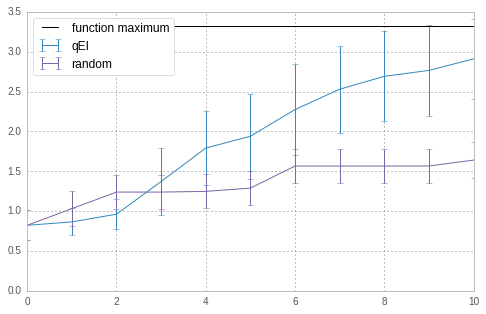

In [5]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

b_obs = pd.DataFrame(best_observed_all)
b_rnd = pd.DataFrame(best_random_all)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.errorbar(range(1 + N_BATCH), b_obs.mean(axis=0), yerr=1.96*b_obs.sem(axis=0), label="qEI")
ax.errorbar(range(1 + N_BATCH), b_rnd.mean(axis=0), yerr=1.96*b_rnd.sem(axis=0), label="random")
plt.plot([1, N_BATCH], [MAX_VAL]*2, 'k', label="function maximum")
ax.set_ylim(bottom=0)
ax.legend(loc="upper left")